<a href="https://colab.research.google.com/github/2024ac05431-cloud/mlsysops/blob/main/Group71_CNN_CIFAR10_Distributed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Group 71**
                            


1.   Aseem Kumar Rai                   2024ac05431 2024ac05431@wilp.bits-pilani.ac.in
2.   Jaiswal Priyanka Suresh Sanjulata 2024ac05392 2024ac05392@wilp.bits-pilani.ac.in
3.  Kamleshsingh Markam               2024ac05189 2024ac05189@wilp.bits-pilani.ac.in
4.  Jahagirdhar Atharva Arun          2023ac05299 2023ac05299@wilp.bits-pilani.ac.in
5.  Karthika E.                       2024ac05310 2024ac05310@wilp.bits-pilani.ac.in

# Implementation
This is an attempt to implement Parameter Server strategy with 6 or less worker nodes and 2 or 1 Parameter server nodes in a google colab environment . This is realised as a cluster with worker and parameter servers running as instances/processes inside the colab with communication via gRPC between worker and Parameter servers.
Since it is colab, we do not have a control over the resources allocated and thus we have simulated the cluster with above mentioned processes/instances ( the code where inprocess cluster is getting created and strategy is configured to use the inprocess cluster ) .
We have first run the sequential method of data input and evaluated the model. After that we ran the same model ( with same data, batch_size , epochs) with parallelisation of data and also evaluated the model.







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import random
import portpicker
import time
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.constraints import MaxNorm
import multiprocessing

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')



In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


50000 , 32,32,3
50000,  1
10000, 32,32,3
10000, 1

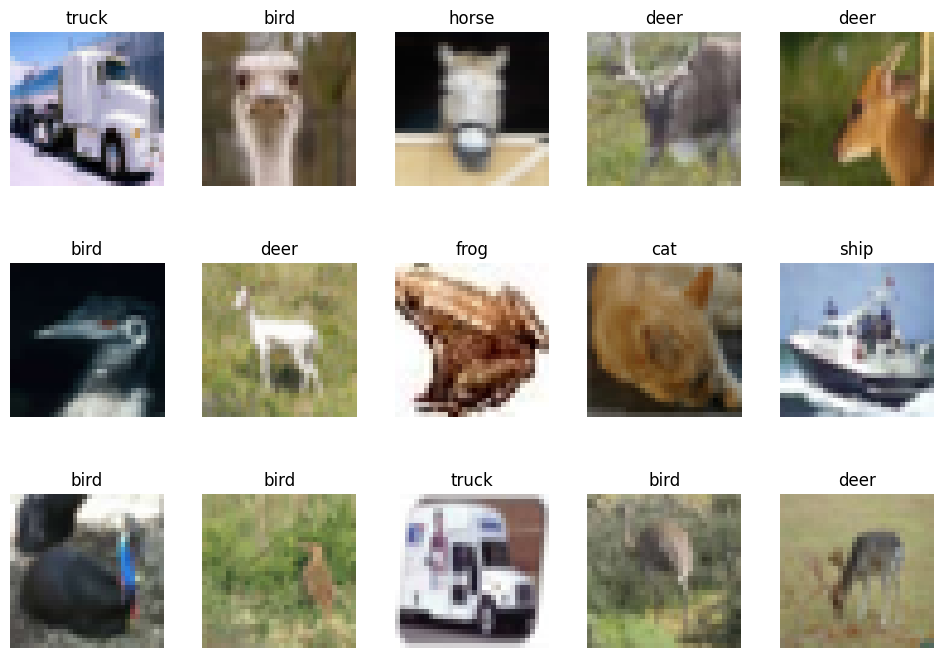

In [ ]:
# x_train, y_train are loaded and contain CIFAR-10 data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.ravel()

for i in range(15):
    index = np.random.randint(0, len(X_train))
    axes[i].imshow(X_train[index])
    axes[i].set_title(class_names[y_train[index][0]])
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)

/tmp/ipython-input-4180544181.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(class_names, rotation = 90)


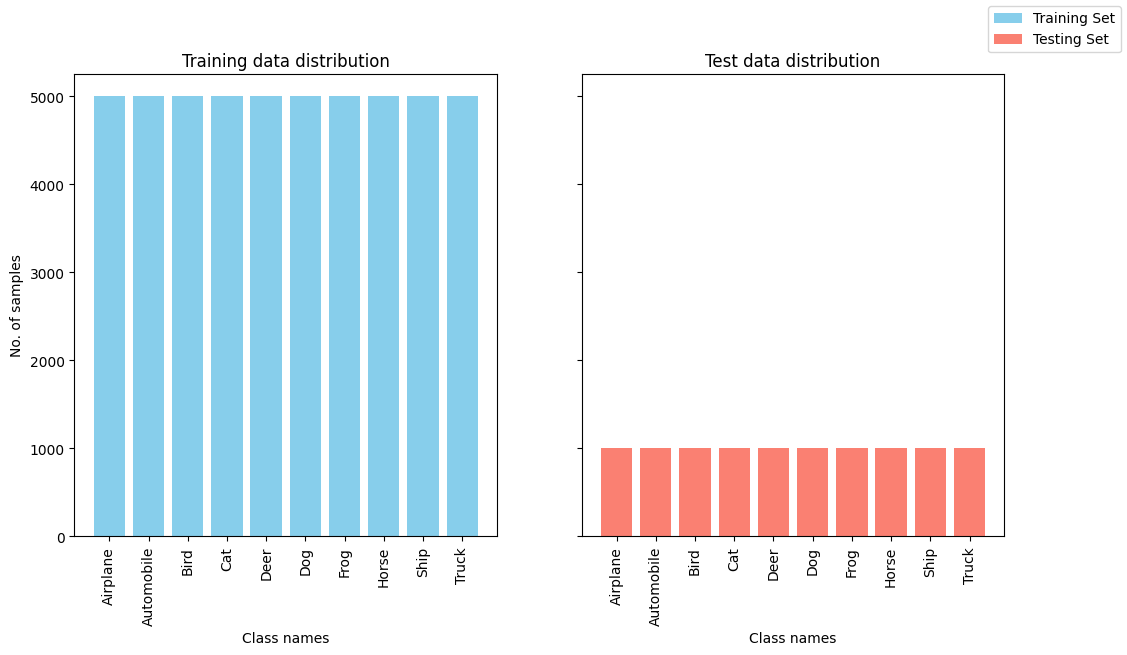

In [ ]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot training set distribution
axs[0].bar(class_names, train_counts, color='skyblue')
axs[0].set_title('Training data distribution')
axs[0].set_xlabel('Class names')
axs[0].set_ylabel('No. of samples')
axs[0].set_xticklabels(class_names, rotation = 90)
# Plot testing set distribution
axs[1].bar(class_names, test_counts, color='salmon')
axs[1].set_title('Test data distribution')
axs[1].set_xlabel('Class names')

# Add a legend to clarify the colors represent training and testing sets
fig.legend(['Training Set', 'Testing Set'])

# plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

#This is the training data created for sequential data to the CNN model .
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

x_train1, x_valid, y_train1, y_valid= train_test_split(X_train, y_cat_train, test_size=0.2, random_state=22)
train_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    fill_mode='nearest',
                    horizontal_flip=True,
                    width_shift_range=0.1,
                    height_shift_range=0.1
                    )
valid_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    fill_mode='nearest',
                    horizontal_flip=True,
                    width_shift_range=0.1,
                    height_shift_range=0.21
                    )
test_datagen = ImageDataGenerator(rescale=1./255)

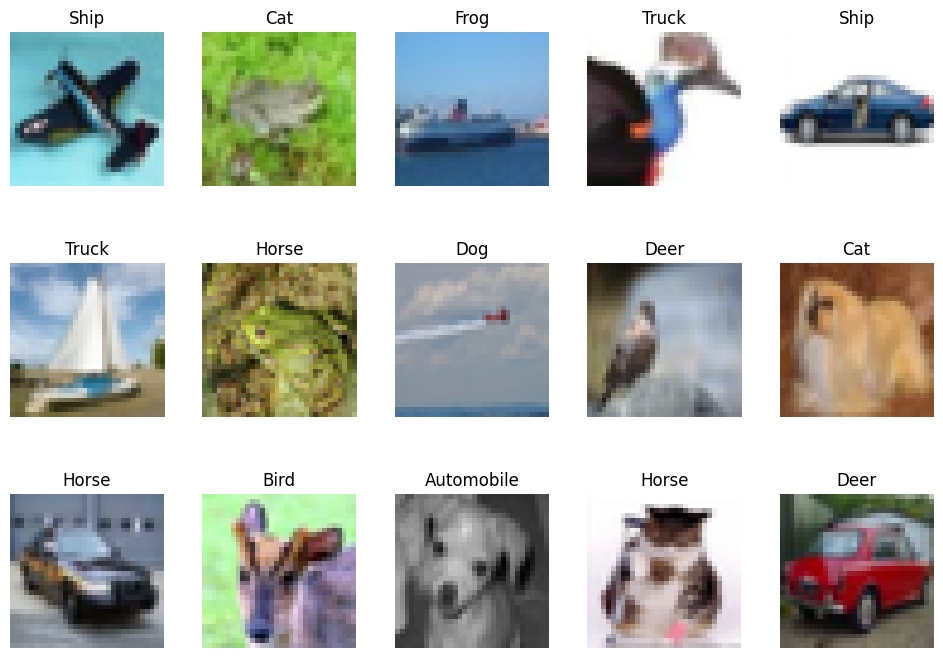

In [ ]:
#Check images randomly to see augmentation
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.ravel()

for i in range(15):
    index = np.random.randint(0, len(x_train1))
    axes[i].imshow(x_train1[index])
    axes[i].set_title(class_names[y_train[index][0]])
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
num_classes=10

# Create the model
start = time.perf_counter()
print("Starting Training.....")
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same', input_shape=(32, 32, 3), kernel_initializer='he_normal', activation='relu' ))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

#Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

#filepath to save the best model
filepath="/content/drive/MyDrive/Colab Notebooks/checkpoint.model_Cifar10.{epoch:02d}.weights.h5"

modelcheckpoint= ModelCheckpoint(filepath=filepath, save_weights_only=True,
                                 monitor='val_accuracy', mode='max', save_best_only=True)
#Define callback
callbacks=[modelcheckpoint]


#Training the model
history = model.fit(
    train_datagen.flow(x_train1, y_train1, batch_size=32),
    validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=32),
    epochs=100,                        # Set a high number of epochs
    callbacks=callbacks                # Include the early stopping callback
)

#------------------------------------------------------------------------------------------------------------------------------------

end = time.perf_counter()
print("Time taken to finish training :", end - start, "seconds")

Starting Training.....


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,578 (1.10 MB)

 Trainable params: 288,938 (1.10 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.3714 - loss: 1.7660 - val_accuracy: 0.4978 - val_loss: 1.3927
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.5892 - loss: 1.1667 - val_accuracy: 0.5518 - val_loss: 1.3178
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.6539 - loss: 0.9823 - val_accuracy: 0.6667 - val_loss: 0.9833
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.6988 - loss: 0.8638 - val_accuracy: 0.7006 - val_loss: 0.8558
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.7262 - loss: 0.8023 - val_accuracy: 0.7358 - val_loss: 0.7620
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.7431 - loss: 0.7383 - val_accuracy: 0.7404 - val_loss: 0.7536
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.7540 - loss: 0.7056 - val_accuracy: 0.7687 - val_loss: 0.6832
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.7702 - los

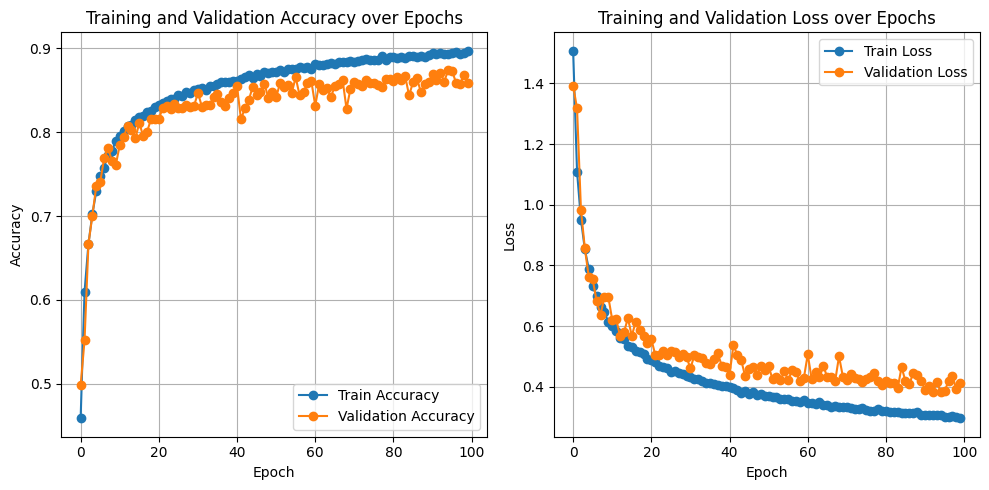

Accuracy: 88.26%


In [ ]:
def plot_convergence():

  plt.figure(figsize=(10, 5))
  # Accuracy plot
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.legend()

  # Loss plot
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], marker='o', label='Train Loss')
  plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
  plt.title('Training and Validation Loss over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.legend()

  plt.tight_layout()
  plt.show()


plot_convergence()


scores = model.evaluate(test_datagen.flow(X_test, y_cat_test,batch_size=32), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# Creating in-process cluster for running parameter server on above CNN .
def create_in_process_cluster(num_workers, num_ps):
  worker_ports = [portpicker.pick_unused_port() for _ in range(num_workers)]
  ps_ports = [portpicker.pick_unused_port() for _ in range(num_ps)]

  cluster_dict = {}
  cluster_dict["worker"] = ["localhost:%s" % port for port in worker_ports]
  if num_ps > 0:
    cluster_dict["ps"] = ["localhost:%s" % port for port in ps_ports]

  cluster_spec = tf.train.ClusterSpec(cluster_dict)

  worker_config = tf.compat.v1.ConfigProto()
  if multiprocessing.cpu_count() < num_workers + 1:
    worker_config.inter_op_parallelism_threads = num_workers + 1

  for i in range(num_workers):
    tf.distribute.Server(
        cluster_spec,
        job_name="worker",
        task_index=i,
        config=worker_config,
        protocol="grpc")

  for i in range(num_ps):
    tf.distribute.Server(
        cluster_spec,
        job_name="ps",
        task_index=i,
        protocol="grpc")

  cluster_resolver = tf.distribute.cluster_resolver.SimpleClusterResolver(
      cluster_spec, rpc_layer="grpc")
  return cluster_resolver


os.environ["GRPC_FAIL_FAST"] = "use_caller"

NUM_WORKERS = 6
NUM_PS = 2
tf.config.set_soft_device_placement(True)
cluster_resolver = create_in_process_cluster(NUM_WORKERS, NUM_PS)

In [ ]:
variable_partitioner = (
    tf.distribute.experimental.partitioners.MinSizePartitioner(
        min_shard_bytes=(256 << 10),
        max_shards=NUM_PS))

strategy = tf.distribute.ParameterServerStrategy(
    cluster_resolver,
    variable_partitioner=None)

global_batch_size = 32

#dataset_training = tf.data.Dataset.from_tensor_slices((x_train1, y_train1)).shuffle(10).repeat()
#dataset_training = dataset_training.batch(global_batch_size)
#dataset_training = dataset_training.prefetch(2)

#dataset_val = tf.data.Dataset.from_tensor_slices((x_valid, x_valid)).shuffle(10).repeat()
#dataset_val = dataset_val.batch(global_batch_size)
#dataset_val = dataset_val.prefetch(2)



def train_dataset_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_train1, y_train1))
    dataset = dataset.shuffle(1000)
    dataset = dataset.repeat()
    dataset = dataset.batch(global_batch_size)
    dataset = dataset.prefetch(2)
    return dataset


def val_dataset_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    dataset = dataset.batch(global_batch_size)
    dataset = dataset.prefetch(2)
    return dataset


coordinator = tf.distribute.experimental.coordinator.ClusterCoordinator(strategy)

distributed_train_dataset = coordinator.create_per_worker_dataset(train_dataset_fn)

distributed_val_dataset = coordinator.create_per_worker_dataset(val_dataset_fn)

num_classes=10
with strategy.scope():

    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Dropout(0.2),

        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(),

        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])

    loss_object = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam()

    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    val_accuracy = tf.keras.metrics.CategoricalAccuracy()
    model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,578 (1.10 MB)

 Trainable params: 288,938 (1.10 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Defining the training step for custom training loop

@tf.function
def train_step(iterator):

    def step_fn(inputs):
        x, y = inputs

        with tf.GradientTape() as tape:
            predictions = model(x, training=True)
            loss = loss_object(y, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_accuracy.update_state(y, predictions)
        return loss

    per_worker_losses = strategy.run(step_fn, args=(next(iterator),))
    mean_loss = strategy.reduce(tf.distribute.ReduceOp.SUM,
                                per_worker_losses,
                                axis=None)
    return mean_loss


In [ ]:
# Defining the validation step for custom training loop

@tf.function
def val_step(iterator):

    def step_fn(inputs):
        x, y = inputs
        predictions = model(x, training=False)
        loss = loss_object(y, predictions)
        val_accuracy.update_state(y, predictions)
        return loss

    per_worker_losses = strategy.run(
        step_fn, args=(next(iterator),)
    )

    mean_loss = strategy.reduce(
        tf.distribute.ReduceOp.SUM,
        per_worker_losses,
        axis=None
    )

    return mean_loss


In [ ]:
epochs = 100
steps_per_epoch = 1562
validation_steps = len(x_valid) // global_batch_size

train_iterator = iter(distributed_train_dataset)
val_iterator = iter(distributed_val_dataset)
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

start = time.perf_counter()
print("Starting Distributed Training.....")

# Defining the training loop for training CNN model defined above.

for epoch in range(epochs):

    train_accuracy.reset_state()
    val_accuracy.reset_state()

    total_train_loss = 0.0
    total_val_loss = 0.0

    # ---- Training ----
    train_futures = []
    for step in range(steps_per_epoch):
        future = coordinator.schedule(train_step, args=(train_iterator,))
        train_futures.append(future)

    coordinator.join()

    for future in train_futures:
        total_train_loss += future.fetch()

    val_iterator = iter(distributed_val_dataset)
    val_futures = []

    # ---- Validation ----
    for step in range(validation_steps):
        future = coordinator.schedule(val_step, args=(val_iterator,))
        val_futures.append(future)

    coordinator.join()

    for future in val_futures:
      total_val_loss += future.fetch()

    # ---- Store metrics ----
    epoch_train_loss = total_train_loss / steps_per_epoch
    epoch_val_loss = total_val_loss / validation_steps

    train_loss_history.append(epoch_train_loss)
    val_loss_history.append(epoch_val_loss)
    train_acc_history.append(train_accuracy.result().numpy())
    val_acc_history.append(val_accuracy.result().numpy())

    print(f"Epoch {epoch+1}/{epochs}=========Train Acc: {train_acc_history[-1]}, Val Acc: {val_acc_history[-1]}  Training Loss : {train_loss_history[-1]}  Validation Loss : {val_loss_history[-1]}")
    #print("Train Acc:", train_acc_history[-1])
    #print("Val Acc:", val_acc_history[-1])
    #print("Training Loss :", train_loss_history[-1])
    #print("Validation Loss :", val_loss_history[-1])

end = time.perf_counter()
print("Time taken to finish Distributed training :", end - start, "seconds")

Starting Distributed Training.....
Epoch 1/100=========Train Acc: 0.482876718044281, Val Acc: 0.4366438388824463  Training Loss : 1.5562375783920288  Validation Loss : 1.7047356367111206
Epoch 2/100=========Train Acc: 0.6837554574012756, Val Acc: 0.6302083134651184  Training Loss : 0.978575587272644  Validation Loss : 1.1416672468185425
Epoch 3/100=========Train Acc: 0.7560016512870789, Val Acc: 0.6680743098258972  Training Loss : 0.7722737789154053  Validation Loss : 1.0173059701919556
Epoch 4/100=========Train Acc: 0.8076545000076294, Val Acc: 0.6826298832893372  Training Loss : 0.6700596809387207  Validation Loss : 1.076296329498291
Epoch 5/100=========Train Acc: 0.8355298638343811, Val Acc: 0.7444620132446289  Training Loss : 0.5939019322395325  Validation Loss : 0.8395175337791443
Epoch 6/100=========Train Acc: 0.8560144305229187, Val Acc: 0.7621753215789795  Training Loss : 0.5281825661659241  Validation Loss : 0.7680302858352661
Epoch 7/100=========Train Acc: 0.8798657059669495,

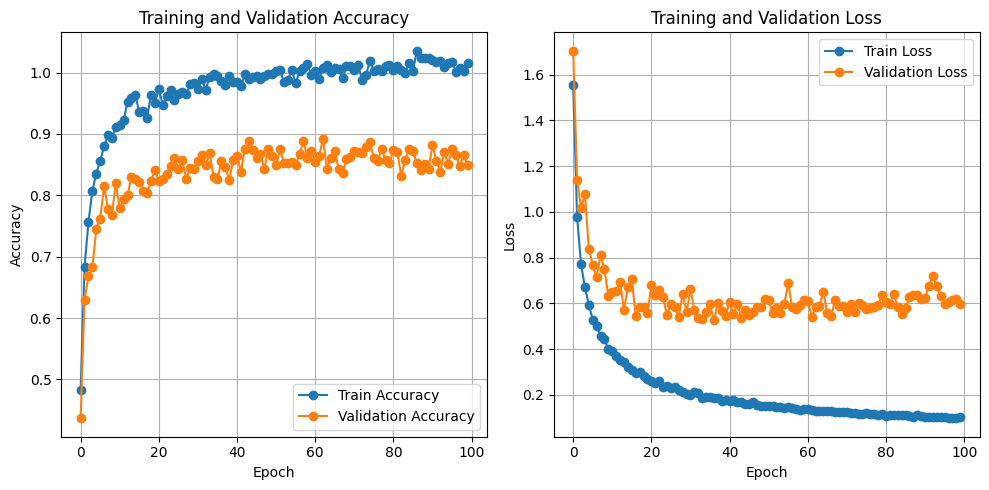

In [ ]:
def plot_convergence():

    plt.figure(figsize=(10, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_acc_history, marker='o', label='Train Accuracy')
    plt.plot(val_acc_history, marker='o', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, marker='o', label='Train Loss')
    plt.plot(val_loss_history, marker='o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_convergence()

In [ ]:
test_accuracy = tf.keras.metrics.CategoricalAccuracy()
test_loss_total = 0.0

def test_dataset_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X_test, y_cat_test))
    dataset = dataset.batch(32)
    return dataset

distributed_test_dataset = coordinator.create_per_worker_dataset(test_dataset_fn)

@tf.function
def test_step(iterator):

    def step_fn(inputs):
        x, y = inputs
        predictions = model(x, training=False)
        loss = loss_object(y, predictions)
        test_accuracy.update_state(y, predictions)
        return loss

    per_worker_losses = strategy.run(step_fn, args=(next(iterator),))

    mean_loss = strategy.reduce(
        tf.distribute.ReduceOp.SUM,
        per_worker_losses,
        axis=None
    )

    return mean_loss

In [ ]:
#Model evaluation with distributed training done above.

test_iterator = iter(distributed_test_dataset)
test_futures = []

test_steps = len(X_test) // 32

for step in range(test_steps):
    future = coordinator.schedule(test_step, args=(test_iterator,))
    test_futures.append(future)

coordinator.join()

for future in test_futures:
    test_loss_total += future.fetch()

final_test_loss = test_loss_total / test_steps
final_test_acc = test_accuracy.result().numpy()

print("Test Loss:", final_test_loss)
print("Test Accuracy: %.2f%%" % (final_test_acc * 100))

Test Loss: 0.59340656
Test Accuracy: 86.48%
